In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os
import itertools
from matplotlib.lines import Line2D

In [2]:
# get previous results
cwd = os.getcwd()
previosu_results_dir = os.path.join(cwd, "results", "previous_results.yml")
with open(previosu_results_dir, 'r') as file:
    previous_results = yaml.safe_load(file)

result_dir = os.path.join(os.getcwd(), "results")
experiment_results_dirs = [x[0] for x in os.walk(result_dir)]
results_dirs = []
for dir in experiment_results_dirs:
    data_dir = os.path.join(result_dir, dir)
    if os.path.exists(os.path.join(data_dir, "results.npz")) and os.path.exists(os.path.join(data_dir, "experiment_config.yml")):
        results_dirs.append(data_dir)

In [9]:
def get_results_fitting_conf(results, conf: dict):
    fitting_results = []
    desc = conf["desc"]
    del conf["desc"]
    label = conf["label"]
    del conf["label"]
    for result in results:
        experiment_config_dir = os.path.join(result, "experiment_config.yml")
        assert os.path.exists(experiment_config_dir), "experiment config not found"
        with open(experiment_config_dir) as f:
            experiment_config = yaml.safe_load(f)
        try:
            if all([experiment_config[key]==conf[key] for key in conf.keys()]) and all([el in result for el in desc]):
                fitting_results.append(result)
        except:
            pass
    conf["desc"] = desc
    conf["label"] = label
    if len(fitting_results) == 0:
        print(f"no fitting result found for {conf}")
    if len(fitting_results) > 1:
        print(f"more than one fitting result found for {conf}, {fitting_results}")
    if len(fitting_results) == 1:
        return fitting_results[0], conf
    else:
        return None, None

def get_result_fitting_description(results, desc: list, excludes: list, circuit_name):
    fitting_results = []
    for result in results:
        if all([el in result for el in desc]) and circuit_name in result and not any([el in result for el in excludes]):
            fitting_results.append(result)
    assert len(fitting_results) < 2, f"more than one fitting results found: {fitting_results}"
    if len(fitting_results) == 0:
        print(f"no fitting result found for circuit: {circuit_name} and desc: {desc}")
    if len(fitting_results) == 1:
        return fitting_results[0]
    else:
        return None

def load_results_and_experiment_config(result_dir):
    experiment_config_dir = os.path.join(result_dir, "experiment_config.yml")
    np_data_dir = os.path.join(result_dir, "results.npz")
    assert os.path.exists(experiment_config_dir), "experiment config not found"
    assert os.path.exists(np_data_dir), "result not found"
    with open(experiment_config_dir) as f:
        experiment_config = yaml.safe_load(f)
    data = np.load(np_data_dir, allow_pickle=True)
    my_results = {}
    for k in data.keys():
        # print(f"{k} shape: {data[k].shape}")
        my_results[k] = data[k]
        # print(f"key: {k}, type: {data[k].dtype}, shape: {data[k].shape}")
    return my_results, experiment_config


def get_best_solution(result_data, experiment_config, label):
    # find the relevant points
    assert all([v.dtype != object for v in result_data.values()]), f"Results contain arrays with obj type! {experiment_config['experiment_name']}"
    if "seq_len" in experiment_config:
        expected_size = experiment_config["seq_len"]*len(experiment_config["optimizations"]["aig"])**experiment_config["seq_len"]
        rollout_len = experiment_config["seq_len"]
    elif "num_rand" in experiment_config:
        expected_size = experiment_config["num_rand"]*experiment_config["horizon"]
        rollout_len = experiment_config["horizon"]
    elif "local_actions" == experiment_config["experiment_name"]:
        expected_size = experiment_config["horizon"]
        rollout_len = experiment_config["horizon"]
    else:
        expected_size = experiment_config["train_iterations"]*experiment_config["train_batch_size"]
        rollout_len = experiment_config["horizon"]
    if "None_areas" in [key for key in result_data.keys()]:
        areas = result_data["None_areas"].reshape((-1, rollout_len))
        delays = result_data["None_delays"].reshape((-1, rollout_len))
        actions = result_data["None_actions"].reshape((-1, rollout_len))
        rewards = result_data["None_rewards"].reshape((-1, rollout_len))
    else:
        areas = result_data["areas"].reshape((-1, rollout_len))
        delays = result_data["delays"].reshape((-1, rollout_len))
        actions = result_data["actions"].reshape((-1, rollout_len))
        rewards = result_data["rewards"].reshape((-1, rollout_len))

    if True and "num_rand" in experiment_config:
        expected_size = 1000*experiment_config["horizon"]
        areas = areas[:1000]
        delays = delays[:1000]
        actions = actions[:1000]
        rewards = rewards[:1000]

    if all([x in result_data for x in ["eval_rewards", "eval_areas", "eval_delays", "eval_actions"]]):
        eval_areas = result_data["eval_areas"].reshape((-1, rollout_len))
        eval_delays = result_data["eval_delays"].reshape((-1, rollout_len))
        eval_actions = result_data["eval_actions"].reshape((-1, rollout_len))
        eval_rewards = result_data["eval_rewards"].reshape((-1, rollout_len))
    if all([x in result_data for x in ["greedy_rewards", "greedy_areas", "greedy_delays", "greedy_actions"]]):
        greedy_areas = result_data["greedy_areas"].reshape((-1, rollout_len))
        greedy_delays = result_data["greedy_delays"].reshape((-1, rollout_len))
        greedy_actions = result_data["greedy_actions"].reshape((-1, rollout_len))
        greedy_rewards = result_data["greedy_rewards"].reshape((-1, rollout_len))
    assert areas.size == expected_size, f"areas have unexpexted size, {areas.size}, {expected_size}, {experiment_config['experiment_name']}"
    assert delays.size == expected_size, "delays have unexpected size"
    assert actions.size == expected_size, "actions have unexptected size"
    assert rewards.size == expected_size, "rewards have unexpected size"

    # if "more_actions" in experiment_config["experiment_name"]:
    #     name = "more_actions"
    # elif "basic_actions" in experiment_config["experiment_name"]:
    #     name = "basic_actions"
    # elif "lstm_paper_replication" in experiment_config["experiment_name"]:
    #     name = "lstm_paper_actions"
    # elif "local_actions" in experiment_config["experiment_name"]:
    #     name = "local_actions"
    # else:
    #     name = ""
    #     print("name actions not found")
    # if not any([x in experiment_config["experiment_name"] for x in ["bf", "BF", "random", "Random", "local_actions"]]):
    #     if "use_graph" in experiment_config and experiment_config["use_graph"]:
    #         name += "_G"
    #     if "use_previous_action" in experiment_config and experiment_config["use_previous_action"]:
    #         name += "_PA"
    #     if "use_state" in experiment_config and experiment_config["use_state"]:
    #         name += "_S"
    # elif any(x in experiment_config["experiment_name"] for x in ["random", "Random"]):
    #     name += "_random"
    # elif any(x in experiment_config["experiment_name"] for x in ["bf", "BF"]):
    #     name += "_brute_force"
    
    target_delay = experiment_config["target_delay"]
    valid_areas = areas[delays<=target_delay]

    if valid_areas.size > 0:
        area = valid_areas.min()
        delay = delays[areas==area].min()
    else:
        max_reward_idx = np.argmax(rewards)
        print(f"No solution fullfilling the delay constraing found in {experiment_config['experiment_name']}")
        print(f"max reward: {rewards.flatten()[max_reward_idx]}")
        area = areas.flatten()[max_reward_idx]
        delay = delays.flatten()[max_reward_idx]

    if "eval_rewards" in result_data:
        eval_valid_areas = eval_areas[eval_delays<=target_delay]
        if eval_valid_areas.size > 0:
            eval_area = eval_valid_areas.min()
            eval_delay = eval_delays[eval_areas==eval_area].min()
            # print(f"{name}: eval_area: {eval_area}, eval_delay: {eval_delay}")
            if eval_area < area:
                print(f"eval found a better solution")
                area = eval_area
                delay = eval_delay
    
    if "greedy_reward" in result_data:
        greedy_valid_areas = greedy_areas[greedy_delays<=target_delay]
        if greedy_valid_areas.size > 0:
            greedy_area = greedy_valid_areas.min()
            greedy_delay = greedy_delays[greedy_areas==greedy_area].min()
            # print(f"{name}: greedy_area: {greedy_area}, greedy_delay: {greedy_delay}")
            if greedy_area < area:
                print(f"greedy found a better solution")
                area = greedy_area
                delay = greedy_delay
            
    return area, delay, label


def plot_results_for_circuit(previous_results, results_dirs, configs, circuit_name):  # (previous_results, results_dirs, descriptions, excludes, circuit_name):
    fitting_results = []
    for conf in configs:
        conf["circuit_name"] = circuit_name
        fitting_dir, fitting_conf = get_results_fitting_conf(results_dirs, conf)
        if fitting_dir is not None:
            fitting_results.append([fitting_dir, fitting_conf])

    results_data = []
    for fitting_res in fitting_results:
        results_data.append(load_results_and_experiment_config(fitting_res[0]))

    best_results = []
    for result_data, fitting_res in zip(results_data, fitting_results):
        best_results.append(get_best_solution(*result_data, fitting_res[1]["label"]))

    fig, ax = plt.subplots()

    markers = itertools.cycle(["o", "+", "1", "2", "3", "*", "x"])

    for methode, res in previous_results.items():
        ax.scatter(res[circuit_name]["area"], res[circuit_name]["delay"], label=methode, marker=next(markers))

    for best_result in best_results:
        ax.scatter(best_result[0], best_result[1], label=best_result[2], marker=next(markers))

    experiment_config = results_data[0][1]
    print(experiment_config["target_delay"])
    ax.autoscale(True)
    ax.axhline(y=experiment_config["target_delay"], linewidth=1, color='red', linestyle='--')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True)
    ax.set_ylabel("Delay [ns]")
    ax.set_xlabel("Area [μm²]")
    ax.set_title(label=experiment_config["circuit_name"].capitalize())
    plt.savefig("test_plot.svg", bbox_inches="tight")
    plt.show()

def get_ranking_and_solutions(previous_results, results_dirs, configs, my_best_only=False, inc_prev_res=True):
    ranks = {}
    solutions = {}
    circuit_names = ["adder", "bar", "log2", "max", "multiplier", "sine", "sqrt", "square"]
    for circuit_name in circuit_names:
        fitting_results = []
        for conf in configs:
            conf["circuit_name"] = circuit_name
            fitting_dir, fitting_conf = get_results_fitting_conf(results_dirs, conf)
            if fitting_dir is not None:
                fitting_results.append([fitting_dir, fitting_conf])

        results_data = []
        for result_dir in fitting_results:
            results_data.append(load_results_and_experiment_config(result_dir[0]))

        best_results = []
        for result_data, fitting_result in zip(results_data, fitting_results):
            best_results.append(get_best_solution(*result_data, fitting_result[1]["label"]))

        # get the rankings
        target_delay = results_data[0][1]["target_delay"]
        areas = [res[0] if res[1] <= target_delay else float('inf') for res in best_results]
        delays = [res[1] for res in best_results]
        names = [res[2] for res in best_results]

        if my_best_only:
            areas = [min(areas)]
            delays = [delays[areas.index(min(areas))]]
            names = ["my_best_methode"]

        if inc_prev_res:
            for methode, res in previous_results.items():
                names.append(methode)
                delays.append(res[circuit_name]["delay"])
                if res[circuit_name]["delay"] <= target_delay:
                    areas.append(res[circuit_name]["area"])
                else:
                    areas.append(float('inf'))

        for name, area in zip(names, areas):
            print(f"{name}: {area}")
            
        areas = np.array(areas)
        delays = np.array(delays)

        solutions[circuit_name] = [areas, delays, names]

        for area, name in zip(areas, names):
            if not name in ranks:
                ranks[name] = []
            ranks[name].append(np.sum(area-0.5 >= areas)+1)
            # print(f"{name}: {np.sum(area-0.5 >= areas)}")
        
    # calculate average rank
    avg_ranks = {}
    for name, ran in ranks.items():
        avg_ranks[name] = sum(ran)/len(ran)

    print(avg_ranks)
    return ranks, solutions

def plot_bars(solutions):

    names = solutions["adder"][2]
    circuit_names = ["adder", "bar", "log2", "max", "multiplier", "sine", "sqrt", "square"]
    sols = {}
    for name in names:
        sols[name] = []
        for circuit_name in circuit_names:
            # assert name == solutions[circuit_name][2][idx], f"solutions not aligned {name}, {solutions[circuit_name][2][idx]}"
            idx = solutions[circuit_name][2].index(name)
            sols[name].append(solutions[circuit_name][0][idx])

    fig, ax = plt.subplots()
    x = np.arange(len(solutions))*5
    num_names = len(sols)
    width = 5/(num_names+1)
    offset = -num_names/2 + 0.5
    for name, sol in sols.items():
        sol_arr = np.array(sol)/np.array(sols["drills"])
        ax.bar(x + offset*width, sol_arr, width, label=name)
        offset+=1
    plt.savefig("test_plot.svg", bbox_inches="tight")
    plt.show()


def plot_result_space(results, description, excludes, circuit_name):
    result_dir = get_result_fitting_description(results, description, excludes, circuit_name)
    results, config = load_results_and_experiment_config(result_dir)
    if "random" in description:
        results["areas"] = results["areas"][:1000]
        results["delays"] = results["delays"][:1000]
        results["actions"] = results["actions"][:1000]

    if True:
        areas = results["areas"].reshape((-1, 40))
        delays = results["delays"].reshape((-1, 40))
        actions = results["actions"].reshape((-1, 40))
        min_valid_area = areas[delays<=config["target_delay"]].min()
        # find some interesting facts about the solution space
        print(f"Num of rollouts: {areas.shape[0]}")
        print(f"Num of unique areas: {np.unique(areas).shape[0]}")
        print(f"Num of unique delays: {np.unique(delays).shape[0]}")
        print(f"Num of valid Solutions: {np.sum(delays<=config['target_delay'])}")
        unique_area_delay_combinations = set()
        for area, delay in zip(areas.flatten(), delays.flatten()):
            unique_area_delay_combinations.add((area, delay))
        print(f"Num of unique area-delay combinations: {len(unique_area_delay_combinations)}")

        min_valid_area_indices = np.argwhere(areas==min_valid_area)
        print(min_valid_area_indices)
        print(areas.shape)
        print(f"Num of optimal solutions: {min_valid_area_indices.shape[0]}")

        unique_optimal_tradjectories = set()
        for row, column in min_valid_area_indices:
            unique_optimal_tradjectories.add(tuple(actions[row, :column+1].tolist()))

        optimal_tradjectories = []
        for row, column in min_valid_area_indices:
            optimal_tradjectories.append(actions[row, :column+1].tolist())

        print(f"num of unique optimal trajectories: {len(unique_optimal_tradjectories)}")
        print(f"num of optimal trajectories: {len(optimal_tradjectories)}")

        for tradjectory in optimal_tradjectories:
            print(tradjectory)

    best_area, delay_ba, _ = get_best_solution(results, config, None)

    print(f"{best_area:.2f} & {delay_ba:.2f} & {np.mean(results['areas'].flatten()):.2f} & {np.mean(results['delays'].flatten()):.2f}")
            
    fig, ax = plt.subplots()
    ax.axhline(y=config["target_delay"], linewidth=1, color='red', linestyle='--')
    ax.scatter(results["areas"].flatten(), results["delays"].flatten(), s=2, alpha=0.1, label="All Results")
    ax.scatter(np.mean(results["areas"].flatten()), np.mean(results["delays"].flatten()), s=8, color='red')
    ax.scatter(best_area, delay_ba, s=8, color='C2')
    ax.grid(True)
    h1 = Line2D([0], [0], marker='o', markersize=np.sqrt(20), color='C0', linestyle='None')
    h2 = Line2D([0], [0], marker='o', markersize=np.sqrt(20), color='r', linestyle='None')
    h3 = Line2D([0], [0], marker='o', markersize=np.sqrt(20), color='C2', linestyle='None')
    ax.legend([h1, h2, h3], ["All Results", "Average Result", "Best Result"], markerscale=2)
    ax.set_ylabel("Delay [ns]")
    ax.set_xlabel("Area [μm²]")
    # ax.set_xlim([600, 1600])
    ax.set_title(label=config["circuit_name"].capitalize())
    plt.savefig("test_plot.png", bbox_inches="tight")
    plt.show()


def plot_avg_reward_step(result_dirs, descriptions, excludes):
    circuit_names = ["adder", "bar", "log2", "max", "multiplier", "sine", "sqrt", "square"]
    fig, ax = plt.subplots()
    for description, exclude in zip(descriptions, excludes):
        all_circuits_rewards = []
        for circuit_name in circuit_names:
            result_dir = get_result_fitting_description(result_dirs, description, exclude, circuit_name)
            result, config = load_results_and_experiment_config(result_dir)
            all_circuits_rewards.append(result["rewards"])

        all_circuits_rewards = np.stack(all_circuits_rewards).squeeze()
        print(all_circuits_rewards.shape)
        if "mode" in config and config["mode"] == "random":
            label = "Random"
            y = all_circuits_rewards[:, :1000, :]
            y = np.sum(y, axis = -1)
            y = y.reshape(8, 100, 10)
            y = np.mean(y, axis = (0, 2))
        else:
            label = "PPO"
            y = np.sum(all_circuits_rewards, axis = -1)
            y = np.mean(y, axis=(0, 1))


        x = np.arange(400, 40400, 400)
        ax.plot(x, y, label = label)

    ax.set_title("Episode Reward: PPO vs Random")
    ax.set_xlabel("Step Number")
    ax.set_ylabel("Average Episode Reward")
    ax.legend()
    plt.savefig("test_plot.svg", bbox_inches="tight")
    fig.show()


def best_valid_solution_vs_step(result_dirs, descriptions, excludes, circuit_name):
    fig, ax = plt.subplots()
    for description, exclude in zip(descriptions, excludes):

        result_dir = get_result_fitting_description(result_dirs, description, exclude, circuit_name)
        result, config = load_results_and_experiment_config(result_dir)
        
        if "mode" in config and config["mode"] == "random":
            label = "Random"
            target_delay = config["target_delay"]
            areas = result["areas"][:1000]
            delays = result["delays"][:1000]
        else:
            label = "PPO"
            areas = np.swapaxes(result["areas"].squeeze(), 0, 1).reshape((1000, 40))
            delays = np.swapaxes(result["delays"].squeeze(), 0, 1).reshape((1000, 40))

        target_delay = config["target_delay"]
        areas = np.where(delays <= target_delay, areas, np.inf)
        areas = np.min(areas, axis=1)
        current_best = np.inf
        current_best_areas = []
        for area in areas:
            if area < current_best:
                current_best = area
            current_best_areas.append(current_best)

        x = np.arange(0, 1000)
        y = np.array(current_best_areas)
        ax.plot(x, y, label = label)

        print(areas.shape)

    ax.set_title(f"{circuit_name.capitalize()}")
    ax.set_xlabel("Episode Number")
    ax.set_ylabel("Best Valid Area")
    ax.legend()

    plt.savefig("test_plot.svg", bbox_inches="tight")
    fig.show()

(1000,)
(1000,)


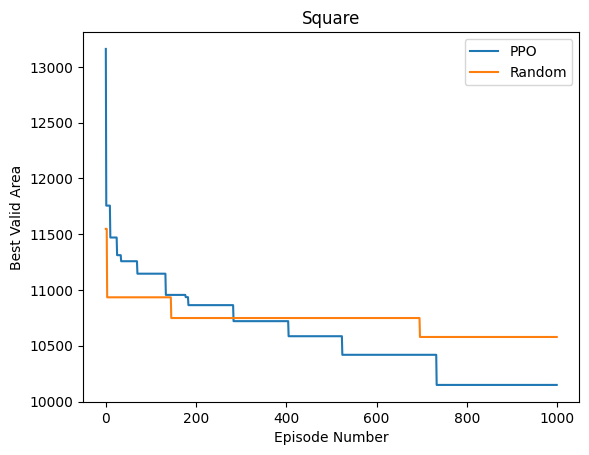

In [15]:
best_valid_solution_vs_step(results_dirs, [["more_actions_global_state", "PPO"], ["more_actions", "random"]], [["gcn", "previous_actions"], []], "square")

(8, 10, 100, 40)
(8, 5000, 40)


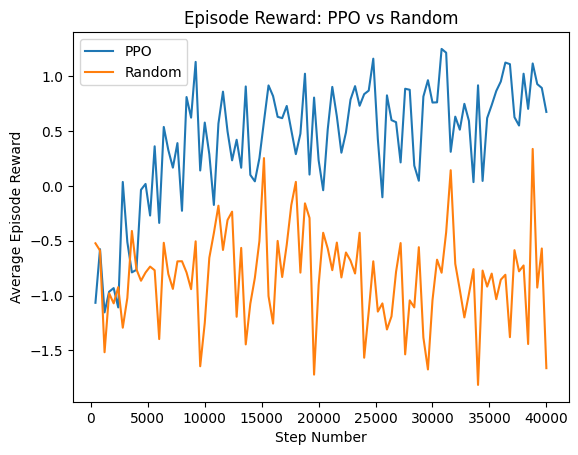

In [108]:
plot_avg_reward_step(results_dirs, [["more_actions_global_state_actions_gcn", "PPO"], ["more_actions", "random"]], [[], []])

In [20]:
configs=[
        {
            "use_graph": True,
            "use_previous_action": True,
            "use_state": True,
            "desc": ["basic_actions"],
            "label": "basic_actions_G_PA_S"
        },
        {
            "desc": ["basic_actions_BF"],
            "label": "basic_actions_brute_force"
        },
        {
            "desc": ["basic_actions_random"],
            "label": "basic_actions_random"
        },
        {
            "use_graph": True,
            "use_previous_action": True,
            "use_state": True,
            "desc": ["more_actions"],
            "label": "more_actions_G_PA_S"
        },
        {
            "use_graph": True,
            "use_previous_action": True,
            "use_state": False,
            "desc": ["more_actions"],
            "label": "more_actions_G_PA"
        },
        {
            "use_graph": True,
            "use_previous_action": False,
            "use_state": True,
            "desc": ["more_actions"],
            "label": "more_actions_G_S"
        },
        {
            "use_graph": True,
            "use_previous_action": False,
            "use_state": False,
            "desc": ["more_actions"],
            "label": "more_actions_G"
        },
        {
            "use_graph": False,
            "use_previous_action": True,
            "use_state": True,
            "desc": ["more_actions"],
            "label": "more_actions_PA_S"
        },
        {
            "use_graph": False,
            "use_previous_action": True,
            "use_state": False,
            "desc": ["more_actions"],
            "label": "more_actions_PA"
        },
        {
            "use_graph": False,
            "use_previous_action": False,
            "use_state": True,
            "desc": ["more_actions"],
            "label": "more_actions_S"
        },
        {
            "desc": ["more_actions_random"],
            "label": "more_actions_random"
        },
        {
            "desc": ["more_actions_bf"],
            "label": "more_actions_brute_force"
        },
        {
            "desc": ["local_actions"],
            "sparse": True,
            "global_softmax": True,
            "horizon": 4000000,
            "optimizations": ["rewrite", "rewrite -z", "refactor", "refactor -z", "resub", "balance", 
            "balance -d", 
            "desub", 
            "no_action"
            ],
            "label": "local_actions"
        },
        # {
        #     "desc": ["local_actions"],
        #     "sparse": True,
        #     "global_softmax": True,
        #     "horizon": 4000000,
        #     "optimizations": ["rewrite", "rewrite -z", "refactor", "refactor -z", "resub", "balance", 
        #     # "balance -d", 
        #     "desub", 
        #     "no_action"
        #     ],
        #     "label": "local_actions_No-balance-d"
        # },
        #         {
        #     "desc": ["local_actions"],
        #     "sparse": True,
        #     "global_softmax": True,
        #     "horizon": 4000000,
        #     "optimizations": ["rewrite", "rewrite -z", "refactor", "refactor -z", "resub", "balance", 
        #     "balance -d", 
        #     # "desub", 
        #     "no_action"
        #     ],
        #     "label": "local_actions_No-desub"
        # },
                {
            "desc": ["local_actions"],
            "sparse": True,
            "global_softmax": True,
            "horizon": 4000000,
            "optimizations": ["rewrite", "rewrite -z", "refactor", "refactor -z", "resub", "balance", 
            # "balance -d", 
            # "desub", 
            "no_action"
            ],
            "label": "local_actions_No-desub_No-balance-d"
        },
    ]

no fitting result found for {'sparse': True, 'global_softmax': True, 'horizon': 4000000, 'optimizations': ['rewrite', 'rewrite -z', 'refactor', 'refactor -z', 'resub', 'balance', 'balance -d', 'desub', 'no_action'], 'circuit_name': 'sine', 'desc': ['local_actions'], 'label': 'local_actions'}
3800


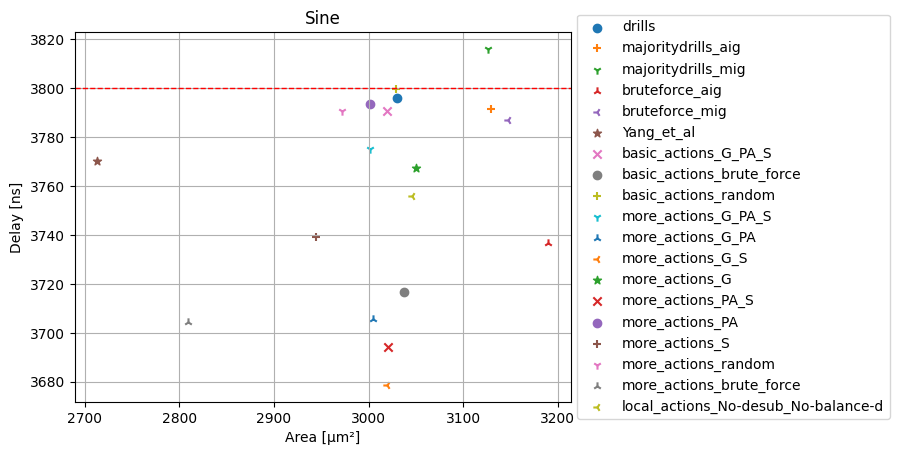

In [21]:
plot_results_for_circuit(
    previous_results,
    results_dirs,
    configs=configs,
    circuit_name="sine")

In [57]:
ranks, solutions = get_ranking_and_solutions(previous_results, results_dirs, configs, my_best_only=True, inc_prev_res=True)

No solution fullfilling the delay constraing found in local_actions
max reward: 1280.5400126663817
no fitting result found for {'sparse': True, 'global_softmax': True, 'horizon': 4000000, 'optimizations': ['rewrite', 'rewrite -z', 'refactor', 'refactor -z', 'resub', 'balance', 'balance -d', 'desub', 'no_action'], 'circuit_name': 'log2', 'desc': ['local_actions'], 'label': 'local_actions'}
no fitting result found for {'sparse': True, 'global_softmax': True, 'horizon': 4000000, 'optimizations': ['rewrite', 'rewrite -z', 'refactor', 'refactor -z', 'resub', 'balance', 'desub', 'no_action'], 'circuit_name': 'log2', 'desc': ['local_actions'], 'label': 'local_actions_no-balance-d'}
no fitting result found for {'sparse': True, 'global_softmax': True, 'horizon': 4000000, 'optimizations': ['rewrite', 'rewrite -z', 'refactor', 'refactor -z', 'resub', 'balance', 'balance -d', 'no_action'], 'circuit_name': 'log2', 'desc': ['local_actions'], 'label': 'local_actions_no-desub'}
no fitting result found

In [58]:
for name, rank in ranks.items():
    st = f"{name}"
    st = st.replace("_", "\_")
    for rn in rank:
        st += f" & {rn}"

    st += f" & {sum(rank)/len(rank)}"
    st += "\\\\"
    print(st)
    print("\\hline")

my\_best\_methode & 2 & 2 & 1 & 1 & 2 & 2 & 1 & 1 & 1.5\\
\hline
drills & 5 & 5 & 3 & 3 & 5 & 3 & 6 & 6 & 4.5\\
\hline
majoritydrills\_aig & 3 & 4 & 4 & 4 & 4 & 4 & 5 & 8 & 4.5\\
\hline
majoritydrills\_mig & 7 & 6 & 8 & 7 & 8 & 8 & 4 & 4 & 6.5\\
\hline
bruteforce\_aig & 4 & 1 & 5 & 5 & 3 & 6 & 7 & 3 & 4.25\\
\hline
bruteforce\_mig & 6 & 6 & 8 & 6 & 6 & 5 & 3 & 4 & 5.5\\
\hline
Yang\_et\_al & 1 & 3 & 2 & 2 & 1 & 1 & 2 & 2 & 1.75\\
\hline


2000


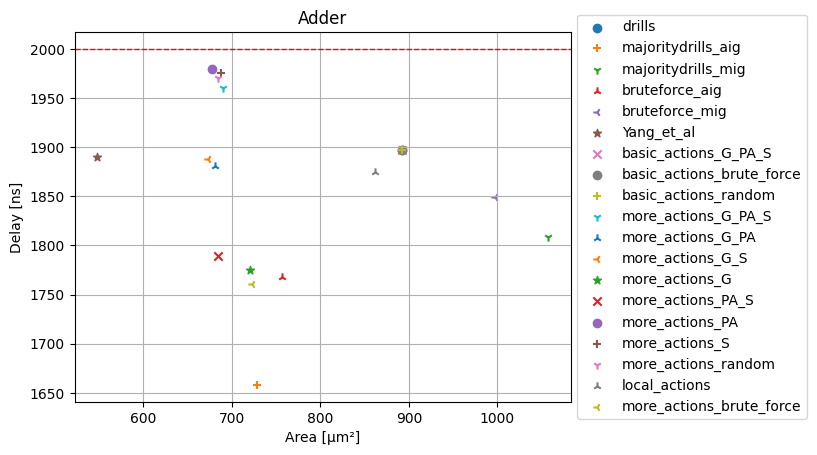

In [14]:
plot_results_for_circuit(
    previous_results,
    results_dirs,
    configs=[
        {
            "use_graph": True,
            "use_previous_action": True,
            "use_state": True,
            "desc": ["basic_actions"]
        },
        {
            "desc": ["basic_actions_BF"]
        },
        {
            "desc": ["basic_actions_random"]
        },
        {
            "use_graph": True,
            "use_previous_action": True,
            "use_state": True,
            "desc": ["more_actions"]
        },
        {
            "use_graph": True,
            "use_previous_action": True,
            "use_state": False,
            "desc": ["more_actions"]
        },
        {
            "use_graph": True,
            "use_previous_action": False,
            "use_state": True,
            "desc": ["more_actions"]
        },
        {
            "use_graph": True,
            "use_previous_action": False,
            "use_state": False,
            "desc": ["more_actions"]
        },
        {
            "use_graph": False,
            "use_previous_action": True,
            "use_state": True,
            "desc": ["more_actions"]
        },
        {
            "use_graph": False,
            "use_previous_action": True,
            "use_state": False,
            "desc": ["more_actions"]
        },
        {
            "use_graph": False,
            "use_previous_action": False,
            "use_state": True,
            "desc": ["more_actions"]
        },
        {
            "desc": ["more_actions_random"]
        },
        {
            "desc": ["local_actions", "23-55"]
        },
        {
            "desc": ["more_actions_bf"]
        },
    ],
    circuit_name="adder")

Num of rollouts: 1000
Num of unique areas: 10087
Num of unique delays: 34819
Num of valid Solutions: 33385
Num of unique area-delay combinations: 35137
[[184  10]]
(1000, 40)
Num of optimal solutions: 1
num of unique optimal trajectories: 1
num of optimal trajectories: 1
[5, 11, 6, 5, 12, 11, 11, 6, 5, 2, 12]
10577.38 & 1936.45 & 13395.81 & 1580.74


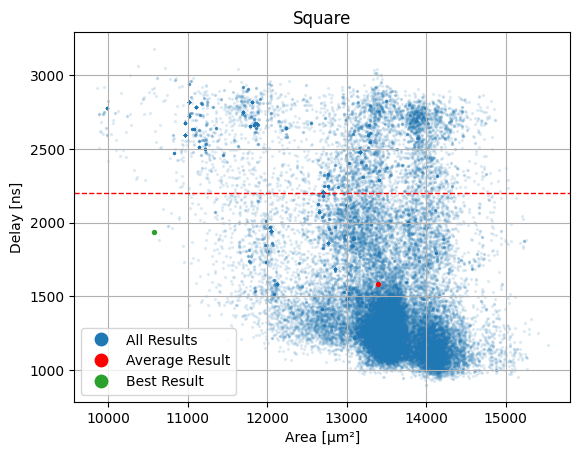

In [38]:
circuit = "square"
plot_result_space(results_dirs, ["more_actions_global_state_actions_gcn", "PPO"], [], circuit)
# plot_result_space(results_dirs, ["more_actions", "random"], [], circuit)

Num of unique area-delay combinations: 20911
Num of optimal solutions: 3
num of unique optimal trajectories: 3
[2.0, 1.0, 3.0, 2.0, 2.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 3.0, 3.0, 5.0, 6.0, 2.0, 6.0, 1.0, 6.0, 5.0]
[2.0, 1.0, 3.0, 2.0, 2.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 3.0, 3.0, 5.0, 6.0, 2.0, 6.0, 1.0, 6.0, 5.0, 0.0]
[2.0, 1.0, 3.0, 2.0, 2.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 3.0, 3.0, 5.0, 6.0, 2.0, 6.0, 1.0, 6.0, 5.0, 0.0, 5.0]


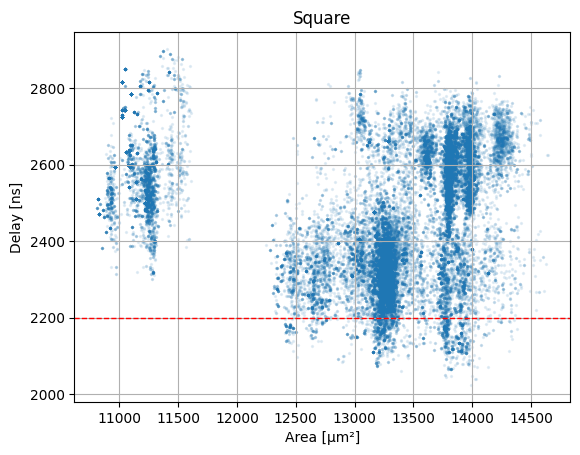

In [42]:
plot_result_space(results_dirs, ["basic_actions", "random"], [], "square")

Plot for local actions

In [4]:
result_dir = os.path.join(os.getcwd(), "results", "local_actions")
experiment_results_dirs = [x[0] for x in os.walk(result_dir)]
results_dirs = []
for dir in experiment_results_dirs:
    data_dir = os.path.join(result_dir, dir)
    if os.path.exists(os.path.join(data_dir, "results.npz")) and os.path.exists(os.path.join(data_dir, "experiment_config.yml")):
        results_dirs.append(data_dir)

In [12]:
def plot_local_actions(configs, metric, circuit_name, results_dirs):
    fitting_dirs = []
    fitting_confs = []
    for conf in configs:
        conf["circuit_name"] = circuit_name
        fitting_dir, fitting_conf = get_results_fitting_conf(results_dirs, conf)
        if fitting_dir is not None:
            fitting_dirs.append(fitting_dir)
            fitting_confs.append(fitting_conf)

    results = []
    experiment_configs = []
    for fitting_dir in fitting_dirs:
        result, experiment_config = load_results_and_experiment_config(fitting_dir)
        results.append(result)
        experiment_configs.append(experiment_config)

    fig, ax = plt.subplots(nrows=4)

    for result, config in zip(results, configs):
        ax.plot(np.arange(config["horizon"])[::100], result[metric][0][::100], label=config["label"])

    ax.set_xlabel("Step Number")
    ax.set_ylabel("Area [μm²]")  # manually change label
    ax.set_title(circuit_name)

    ax.grid(True)
    ax.set_title(label=config["circuit_name"].capitalize())
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    plt.savefig("test_plot.png", bbox_inches="tight")
    plt.show()
    

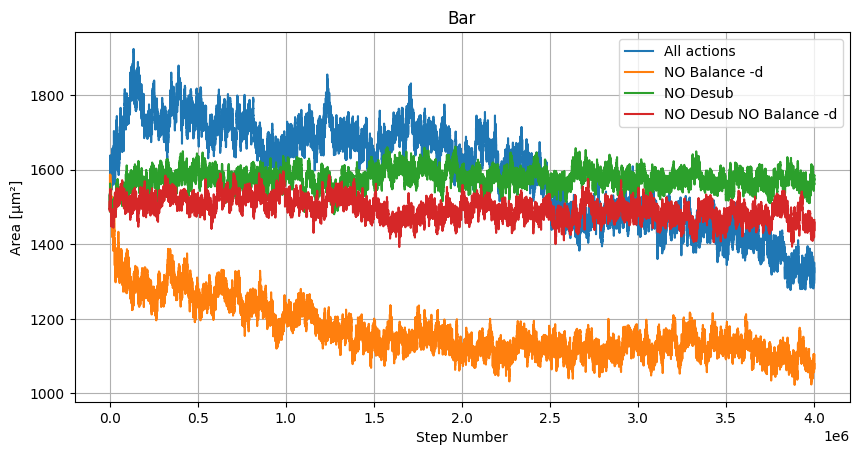

In [14]:
configs = [
    {
        "desc": ["local_actions"],
        "sparse": True,
        "global_softmax": True,
        "horizon": 4000000,
        "optimizations": ["rewrite", "rewrite -z", "refactor", "refactor -z", "resub", "balance", 
        "balance -d", 
        "desub", 
        "no_action"
        ],
        "label": "All actions"
    },
    {
        "desc": ["local_actions"],
        "sparse": True,
        "global_softmax": True,
        "horizon": 4000000,
        "optimizations": ["rewrite", "rewrite -z", "refactor", "refactor -z", "resub", "balance", 
        # "balance -d", 
        "desub", 
        "no_action"
        ],
        "label": "NO Balance -d"
    },
    {
        "desc": ["local_actions"],
        "sparse": True,
        "global_softmax": True,
        "horizon": 4000000,
        "optimizations": ["rewrite", "rewrite -z", "refactor", "refactor -z", "resub", "balance", 
        "balance -d", 
        # "desub", 
        "no_action"
        ],
        "label": "NO Desub"
    },
    {
        "desc": ["local_actions"],
        "sparse": True,
        "global_softmax": True,
        "horizon": 4000000,
        "optimizations": ["rewrite", "rewrite -z", "refactor", "refactor -z", "resub", "balance", 
        # "balance -d", 
        # "desub", 
        "no_action"
        ],
        "label": "NO Desub NO Balance -d"
    },
]

plot_local_actions(configs, "areas", "bar", results_dirs)

In [4]:
# The name of the experiment
experiment_env = "Abc_Env"
experiment_circuit = "adder"
experiment_algo = "PPO"
experiment_date = "2023-01-03-20-03"
experiment_tag = "lstm_replication"
experiment_string = f"{experiment_env}_{experiment_circuit}_{experiment_algo}_{experiment_date}"
if experiment_tag is not None:
    experiment_string += f"_{experiment_tag}"
result_dir = os.path.join(os.getcwd(), "results", experiment_string)
experiment_config_dir = os.path.join(result_dir, "experiment_config.yml")
if not os.path.exists(experiment_config_dir):
    print("experiment config not found")
else:
    with open(experiment_config_dir) as f:
        experiment_config = yaml.safe_load(f)
    print(experiment_config)

np_data_dir = os.path.join(result_dir, "results.npz")
if not os.path.exists(np_data_dir):
    print("result not found")
else:
    data = np.load(np_data_dir)
my_results = {}
for k in data.keys():
    print(f"{k} shape: {data[k].shape}")
    my_results[k] = data[k]


{'MAX_STEPS': 40, 'circuit_file': 'circuits/adder.v', 'circuit_name': 'adder', 'delay_reward_factor': 10, 'env': 'Abc_Env', 'library_file': 'libraries/asap7.lib', 'mockturtle': {'graph_type': 'mig'}, 'optimizations': {'aig': ['rewrite', 'rewrite -z', 'refactor', 'refactor -z', 'resub', 'resub -z', 'balance', 'dc2', 'ifraig', 'dch -f; dc2', 'dch -f; if -g', 'if -g'], 'mig': ['rewrite', 'rewrite -azg', 'rewrite -udc', 'rewrite -pd', 'rewrite -azg -udc', 'rewrite -azg -pd', 'rewrite -udc -pd', 'rewrite -azg -udc -pd', 'balance', 'balance -c', 'resub', 'resub -pd']}, 'preprocessor_pref': None, 'special_tag': 'lstm_replication', 'target_delay': 2000, 'train_iterations': 50, 'use_graph': True, 'use_previous_action': True}
rewards shape: (20, 1, 50, 40)
areas shape: (20, 1, 50, 40)
delays shape: (20, 1, 50, 40)
actions shape: (20, 1, 50, 40)


In [5]:
# find the relevant points
areas = my_results["areas"].reshape((-1, experiment_config["MAX_STEPS"]))
delays = my_results["delays"].reshape((-1, experiment_config["horizon"]))
actions = my_results["actions"].reshape((-1, experiment_config["horizon"]))
target_delay = experiment_config["target_delay"]
min_valid_area = areas[delays<=target_delay].min()
delay_at_min_valid_area = delays[areas==min_valid_area].max()
print(min_valid_area, delay_at_min_valid_area)

663.4483032226562 1630.807861328125


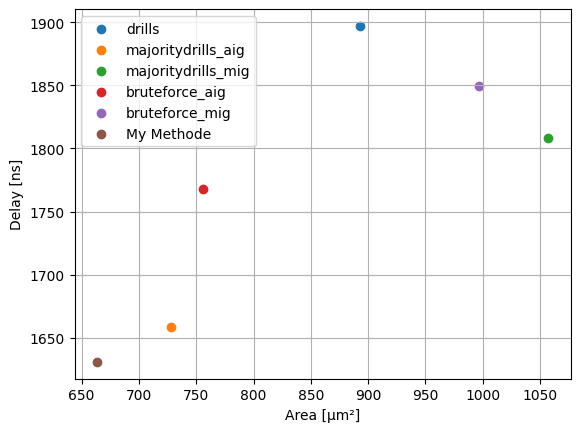

In [6]:
fig, ax = plt.subplots()

circuit = experiment_config["circuit_name"]
for methode, res in previous_results.items():
    ax.scatter(res[circuit]["area"], res[circuit]["delay"], label=methode)

ax.scatter(min_valid_area, delay_at_min_valid_area, label="My Methode")

ax.legend()
ax.grid(True)
ax.set_ylabel("Delay [ns]")
ax.set_xlabel("Area [μm²]")

plt.show()

In [111]:
# find some interesting facts about the solution space
print(f"Num of rollouts: {areas.shape[0]}")
print(f"Num of unique areas: {np.unique(areas).shape[0]}")
print(f"Num of unique delays: {np.unique(delays).shape[0]}")
unique_area_delay_combinations = set()
for area, delay in zip(areas.flatten(), delays.flatten()):
    unique_area_delay_combinations.add((area, delay))
print(f"Num of unique area-delay combinations: {len(unique_area_delay_combinations)}")

min_valid_area_indices = np.argwhere(areas==min_valid_area)
print(f"Num of optimal solutions: {min_valid_area_indices.shape[0]}")

unique_optimal_tradjectories = set()
for row, column in min_valid_area_indices:
    unique_optimal_tradjectories.add(tuple(actions[row, :column+1].tolist()))

optimal_tradjectories = []
for row, column in min_valid_area_indices:
    optimal_tradjectories.append(actions[row, :column+1].tolist())

print(f"num of unique optimal trajectories: {len(unique_optimal_tradjectories)}")
print(f"num of optimal trajectories: {len(optimal_tradjectories)}")

for tradjectory in optimal_tradjectories:
    print(tradjectory)

NameError: name 'areas' is not defined

Automated plots from different trials for all circuits

In [4]:
# check if results are valid

result_dir = os.path.join(os.getcwd(), "results")
experiment_results_dirs = os.listdir(result_dir)
results_dirs = []

for dir in experiment_results_dirs:
    data_dir = os.path.join(result_dir, dir)
    if os.path.exists(os.path.join(data_dir, "results.npz")) and os.path.exists(os.path.join(data_dir, "experiment_config.yml")):
        results_dirs.append(data_dir)
    else:
        print("this dir has no results {dir}")

for dir in results_dirs:
    test_dir =  os.path.join(dir, "results.npz")
    data = np.load(test_dir)
    for key, item in data.items():
        if not(item.dtype == np.int32 or item.dtype == np.float64 or item.dtype == np.int64 or item.shape[-1] == 40):
            print(f"Dir had incorredt data: {dir}, {item.dtype}, {key}")
        else:
            pass
            # print(f"{item.shape}")

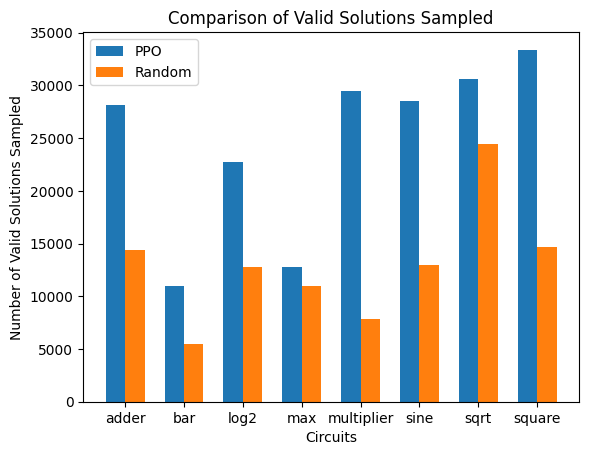

In [11]:
# plot valid solutions

fig, ax = plt.subplots()
x = np.arange(8)
width = 0.33
circuits = ["adder", "bar", "log2", "max", "multiplier", "sine", "sqrt", "square"]
num_valid_sols_ppo = [28181, 10931, 22702, 12794, 29431, 28558, 30587, 33385]
num_valid_sols_rand = [14349, 5497, 12793, 10946, 7848, 12972, 24419, 14717]
ax.bar(x-width/2, num_valid_sols_ppo, width=width, label="PPO")
ax.bar(x+width/2, num_valid_sols_rand, width=width, label="Random")
ax.set_xticks(x)
ax.set_xticklabels(circuits)
ax.set_ylabel("Number of Valid Solutions Sampled")
ax.set_xlabel("Circuits")
ax.set_title("Comparison of Valid Solutions Sampled")
ax.legend()
plt.savefig("test_plot.svg", bbox_inches="tight")
plt.show()
